Задание 10
Для любых видео восстановить траекторию движения (t вектор). Выполнить визуализацию. 
Определить параметры которые влияют на "точность" определения вектора t
Использовать решение на базе нейронных сетей. 
Любые идеи. 

***slam прикрутить. 
Видео 1 но что бы работало.  


При помощи ffmpeg нарезаем видео на картинки с периодичностью 1 секунда. Формат картинок выбираем .png, потому что jpeg
все изображение превращает в квадраты, что может очень сильно помешать поиску особых точек.

In [19]:

import kornia as K;
import kornia.feature as KF;
import numpy as np;
import torch;
from kornia_moons.feature import *;
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import cv2
from tqdm import tqdm
from mpl_toolkits import mplot3d
from kornia_moons.viz import draw_LAF_matches




1 Построим траекторию при помощи детекции точек:

In [5]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [6]:
import cv2

def filter_matches_distance(matches, dist_threshold):    
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

Подберем параметры на двух произвольных картинках:

количество сопоставлений:     670


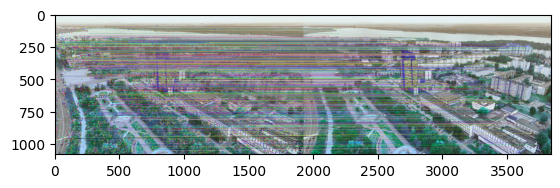

In [23]:
sift = cv2.SIFT_create()

image_1 = cv2.imread('./belkali/i0009.png')
image_2 = cv2.imread('./belkali/i0010.png')
# Сопоставление особых точек (BFMatcher с нормой Hamming)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
keypoints1, descriptors1 = sift.detectAndCompute(image_1, None)
img2=cv2.drawKeypoints(image_1,keypoints1,image_1)
plt.imshow( image_1)
keypoints2, descriptors2 = sift.detectAndCompute(image_2, None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
matcher = cv2.FlannBasedMatcher(index_params, search_params)
matches = matcher.knnMatch(descriptors1, descriptors2, k=2)
# Для оптимизации скорости нахождения сопоставлений подбрем число 0.5 для нахождения примерно 500 точек:
matches = filter_matches_distance(matches,0.2)
print("количество сопоставлений:    ",len(matches))
matched = cv2.drawMatches(image_1, keypoints1, image_2, keypoints2, matches, None, flags=2)
#matched =  cv2.drawMatchesKnn(image_1,keypoints1,image_2,keypoints2,matches,outImg=None,matchColor=(0, 155, 0), 
#                             singlePointColor=(0, 255, 255),                              
#                             flags=0)
plt.imshow( matched)


Количество точек 670 при параметре фильтрации 0.2

Процедура создания траектории по позам.  Каждая поза это 2 матрицы - транслирования и поворота.

In [24]:


def create_trajectory(poses):
    trajectory = [np.array([0, 0, 0])]
    current_pose = np.eye(4)
    pose_cam = [np.array([[0, 0, 0],[0, 0, 0],[0, 0, 0]])]

    for R, t in poses:
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t.T
        
        current_pose = np.dot(current_pose, T)
        trajectory.append(current_pose[:3, 3])
        pose_cam.append(current_pose[:3, :3])

    return np.array(trajectory),np.array(pose_cam)

Далее приведен код нахождения позиций камеры. Каждая позиция это координаты камеры и ее направление.

In [25]:


# Получить список файлов с изображениями
image_folder = "./belkali"
image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".png")])

K = np.array([[3000 ,   0.    , 960],
       [  0.    , 3000 , 540 ],
      [  0.    ,   0.    ,   1.]], dtype=np.float32)

sift = cv2.SIFT_create()

# Сопоставление особых точек (BFMatcher с нормой Hamming)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

poses = []
# Сохранить позиции камеры
positions = [np.array([0, 0, 0])]
kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
# Итерировать через каждую пару соседних изображений
for i in tqdm(range(len(image_files) - 1)):
    try:
       img1 = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)
       #img1 = cv2.filter2D(img1,ddepth=-1,kernel=kernel)
       
       img2 = cv2.imread(image_files[i + 1], cv2.IMREAD_GRAYSCALE)
       #img2 = cv2.filter2D(img2,ddepth=-1,kernel=kernel)       
       #img1 = cv2.undistort(img1, K, dist, None, K)
       #img2 = cv2.undistort(img2, K, dist, None, K)
       keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
       keypoints2, descriptors2 = sift.detectAndCompute(img2, None)      
       
       matches = match_features(descriptors1, descriptors2, matching='BF', detector='sift', sort=True)
       matches = filter_matches_distance(matches, 0.3)
       
       pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
       pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)       
       F, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.LMEDS, prob=0.999, threshold=1.0) 
       a, R, t, b = cv2.recoverPose(F, pts1, pts2, K, mask)       
       poses.append((R, t))
       # Обновить позицию камеры
       current_position = positions[-1]
       new_position = current_position + np.dot(R, t).T[0]
       positions.append(new_position)
    except:
       pass   
  


100%|██████████| 114/114 [05:21<00:00,  2.82s/it]


In [26]:
trajectory,pose_cam = create_trajectory(poses)
pose_cam.shape
trajectory.shape

(115, 3)

In [27]:
def add_trace(trajectory,camera_direction,fig):
    fig.add_trace(go.Scatter3d(
        x=trajectory[:, 0],
        y=trajectory[:, 1],
        z=trajectory[:, 2],
        mode='lines+markers',
        marker=dict(size=2, color='blue'),
        line=dict(color='blue', width=2),
        name='Camera Trajectory'
    ))

    # Добавление ориентации камеры в каждой точке траектории
    for i, (R, t) in enumerate(zip(pose_cam,trajectory)):
        # Направление камеры (ось Z камеры)
        camera_direction = R @ np.array([0, 0, 1])  # Направление оси Z камеры
        camera_direction_end = t + camera_direction * 0.5  # Конец вектора направления

        # Добавляем линию, представляющую направление камеры
        fig.add_trace(go.Scatter3d(
            x=[t[0], camera_direction_end[0]],
            y=[t[1], camera_direction_end[1]],
            z=[t[2], camera_direction_end[2]],
            mode='lines',
            line=dict(color='green', width=2),
            name=f'Camera Direction {i}' if i == 0 else None,
            showlegend=False if i > 0 else True
        ))

In [29]:
import plotly.graph_objects as go
import numpy as np
# Создание фигуры
fig = go.Figure()
fig.add_trace(go.Scatter3d(
        x=trajectory[:, 0],
        y=trajectory[:, 1],
        z=trajectory[:, 2],
        mode='lines+markers',
        marker=dict(size=2, color='blue'),
        line=dict(color='blue', width=2),
        name='Camera Trajectory'
    ))

    # Добавление ориентации камеры в каждой точке траектории
for i, (R, t) in enumerate(zip(pose_cam,trajectory)):
    # Направление камеры (ось Z камеры)
    camera_direction = R @ np.array([0, 0, 1])  # Направление оси Z камеры
    camera_direction_end = t + camera_direction * 0.5  # Конец вектора направления

    # Добавляем линию, представляющую направление камеры
    fig.add_trace(go.Scatter3d(
        x=[t[0], camera_direction_end[0]],
        y=[t[1], camera_direction_end[1]],
        z=[t[2], camera_direction_end[2]],
        mode='lines',
        line=dict(color='green', width=2),
        name=f'Camera Direction {i}' if i == 0 else None,
        showlegend=False if i > 0 else True
    ))

        
#add_trace(trajectory,pose_cam,fig)
# Настройка макета графика
fig.update_layout(
    title='Camera Motion Trajectory',
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis'
    ),
    showlegend=True
)

# Показать график
fig.show()

На видео дрон делает менее одного оборота. На траектории вращение составляет более одного оборота. Возможно, матрица поворота увеличивает свои значения, в результате траектория искажается. 

Далее идет реализация алгоритма на нейросети, однако запустить ее не удалось. 

In [ ]:
def kornia_local_descriptor_function(image, key_points, model):
  with torch.no_grad():
    model.eval()
    timg = K.color.rgb_to_grayscale(K.image_to_tensor(image, False).float()) / 255.
    lafs = laf_from_opencv_SIFT_kpts(key_points)
    affine = KF.LAFAffNetShapeEstimator(True)
    orienter = KF.LAFOrienter(32, angle_detector = KF.OriNet(True))
    orienter.eval()
    affine.eval()
    lafs_new = orienter(affine(lafs, timg), timg)
    patches = KF.extract_patches_from_pyramid(timg, lafs_new, 32)
    B, N, CH, H, W = patches.size()
    descs = model(patches.view(B * N, CH, H, W)).view(B * N, -1)
  return descs.detach().cpu().numpy()

In [32]:
def kornia_points_matching_function(image_1, image_2, model):
  image_1 = cv2.cvtColor(cv2.imread(image_1), cv2.COLOR_BGR2RGB)
  image_2 = cv2.cvtColor(cv2.imread(image_2), cv2.COLOR_BGR2RGB)
  detector_type = cv2.SIFT_create(600)
  
  key_points_1 = detector_type.detect(image_1, None)
  key_points_2 = detector_type.detect(image_2, None)
  print(" found points: ",len(key_points_1))
  descriptor_1 = kornia_local_descriptor_function(image_1, key_points_1, model)
  descriptor_2 = kornia_local_descriptor_function(image_2, key_points_2, model)
  dists, idxs = KF.match_smnn(torch.from_numpy(descriptor_1), torch.from_numpy(descriptor_2), 0.8)
  tentatives = cv2_matches_from_kornia(dists, idxs)
  source_points = np.float32([ key_points_1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
  destination_points = np.float32([ key_points_2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
  F, inliers_mask = cv2.estimateAffine2D(source_points, destination_points)
  draw_params = dict(matchColor = (255,255,0), singlePointColor = None, matchesMask = inliers_mask.ravel().tolist(), flags = 2)
  image_output = cv2.drawMatches(image_1, key_points_1, image_2, key_points_2, tentatives, None, **draw_params)
  plt.figure()
  fig, ax = plt.subplots(figsize = (15, 15))
  ax.imshow(image_output, interpolation = 'nearest')
  print (f'{inliers_mask.sum()} ключевых точек найдено')
  plt.show()

In [33]:
image_1 = './belkali/i0009.png'
image_2 = './belkali/i0010.png'
model = KF.HardNet(False)
kornia_points_matching_function(image_1, image_2, model)





 found points:  601


AttributeError: 'numpy.ndarray' object has no attribute 'color'

In [17]:

#  Повторение нахождения позиций камеры, но с применением нейросети.
# Получить список файлов с изображениями
image_folder = "./belkali"
image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".png")])
model = KF.HardNet(False)
K = np.array([[3000 ,   0.    , 960],
       [  0.    , 3000 , 540 ],
      [  0.    ,   0.    ,   1.]], dtype=np.float32)

sift = cv2.SIFT_create()
model = KF.HardNet(False)
# Сопоставление особых точек (BFMatcher с нормой Hamming)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

poses_kornia = []
# Сохранить позиции камеры
positions = [np.array([0, 0, 0])]
# Итерировать через каждую пару соседних изображений
for i in tqdm(range(len(image_files) - 1)):
    #try:
       #img1 = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)
       #img1 = cv2.filter2D(img1,ddepth=-1,kernel=kernel)
       
       #img2 = cv2.imread(image_files[i + 1], cv2.IMREAD_GRAYSCALE)
       img1 = cv2.cvtColor(cv2.imread(image_files[i]), cv2.COLOR_BGR2RGB)
       img2 = cv2.cvtColor(cv2.imread(image_files[i + 1]), cv2.COLOR_BGR2RGB)
          
       key_points_1 = sift.detect(img1, None)
       key_points_2 = sift.detect(img2, None)
       
       descriptor_1 = kornia_local_descriptor_function(img1, key_points_1, model)
       descriptor_2 = kornia_local_descriptor_function(img2, key_points_2, model)
       
       dists, idxs = KF.match_smnn(torch.from_numpy(descriptor_1), torch.from_numpy(descriptor_2), 0.8)
       tentatives = cv2_matches_from_kornia(dists, idxs)
       source_points = np.float32([ key_points_1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
       destination_points = np.float32([ key_points_2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
       
         
       F, mask = cv2.findEssentialMat(key_points_1, key_points_2, K, method=cv2.LMEDS, prob=0.999, threshold=1.0) 
       a, R, t, b = cv2.recoverPose(F, key_points_1, key_points_2, K, mask)       
       poses_kornia.append((R, t))
       # Обновить позицию камеры
       current_position = positions[-1]
       new_position = current_position + np.dot(R, t).T[0]
       positions.append(new_position)
    #except:
    #   pass     
  

  0%|          | 0/114 [00:04<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'color'

In [14]:
trajectory_k,pose_cam_k = create_trajectory(poses_kornia)
pose_cam_k.shape
trajectory_k.shape

(1, 3)